## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.handlers import do
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

rng = np.random.default_rng(seed=42)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
def generate_data(rng, alpha=5, beta=0, gamma=3, delta=2, n=100, seed=1):
    np.random.seed(seed)

    # Individuals
    individual = range(1, n + 1)

    # Treatment status
    d = rng.binomial(1, 0.5, n)

    # Individual outcome pre-treatment
    y0 = alpha + beta * d + rng.normal(0, 1, n)
    y1 = y0 + gamma + delta * d + rng.normal(0, 1, n)

    # Generate the dataframe
    return pd.DataFrame(
        {"individual": individual, "ad_campaign": d, "revenue0": y0, "revenue1": y1}
    )

In [3]:
data_df = generate_data(rng)
data_df.head()

,individual,ad_campaign,revenue0,revenue1
0,1,1,5.399774,10.394652
1,2,0,4.094521,6.931078
2,3,1,4.621837,9.959412
3,4,1,6.299228,12.706710
4,5,0,4.643736,7.734321


In [4]:
difference_in_means = (
    data_df.query("ad_campaign == True")["revenue1"].mean()
    - data_df.query("ad_campaign == False")["revenue1"].mean()
)

print(f"Difference in means: {difference_in_means:.3f}")

Difference in means: 1.927


In [5]:
ad_campaign = data_df.ad_campaign.to_numpy()
revenue0 = data_df.revenue0.to_numpy()
revenue1 = data_df.revenue1.to_numpy()

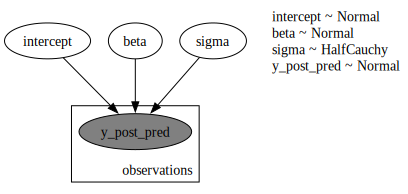

In [6]:
def difference_in_means_model(y_post, treatment) -> None:
    n_samples = len(treatment)
    intercept = numpyro.sample("intercept", dist.Normal(0, 2))
    beta = numpyro.sample("beta", dist.Normal(0, 3))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2))

    mu = intercept + beta * treatment

    with numpyro.plate("observations", n_samples):
        numpyro.sample("y_post_pred", dist.Normal(mu, sigma), obs=y_post)


numpyro.render_model(
    difference_in_means_model,
    model_args=(revenue1, ad_campaign),
    render_distributions=True,
    render_params=True,
)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

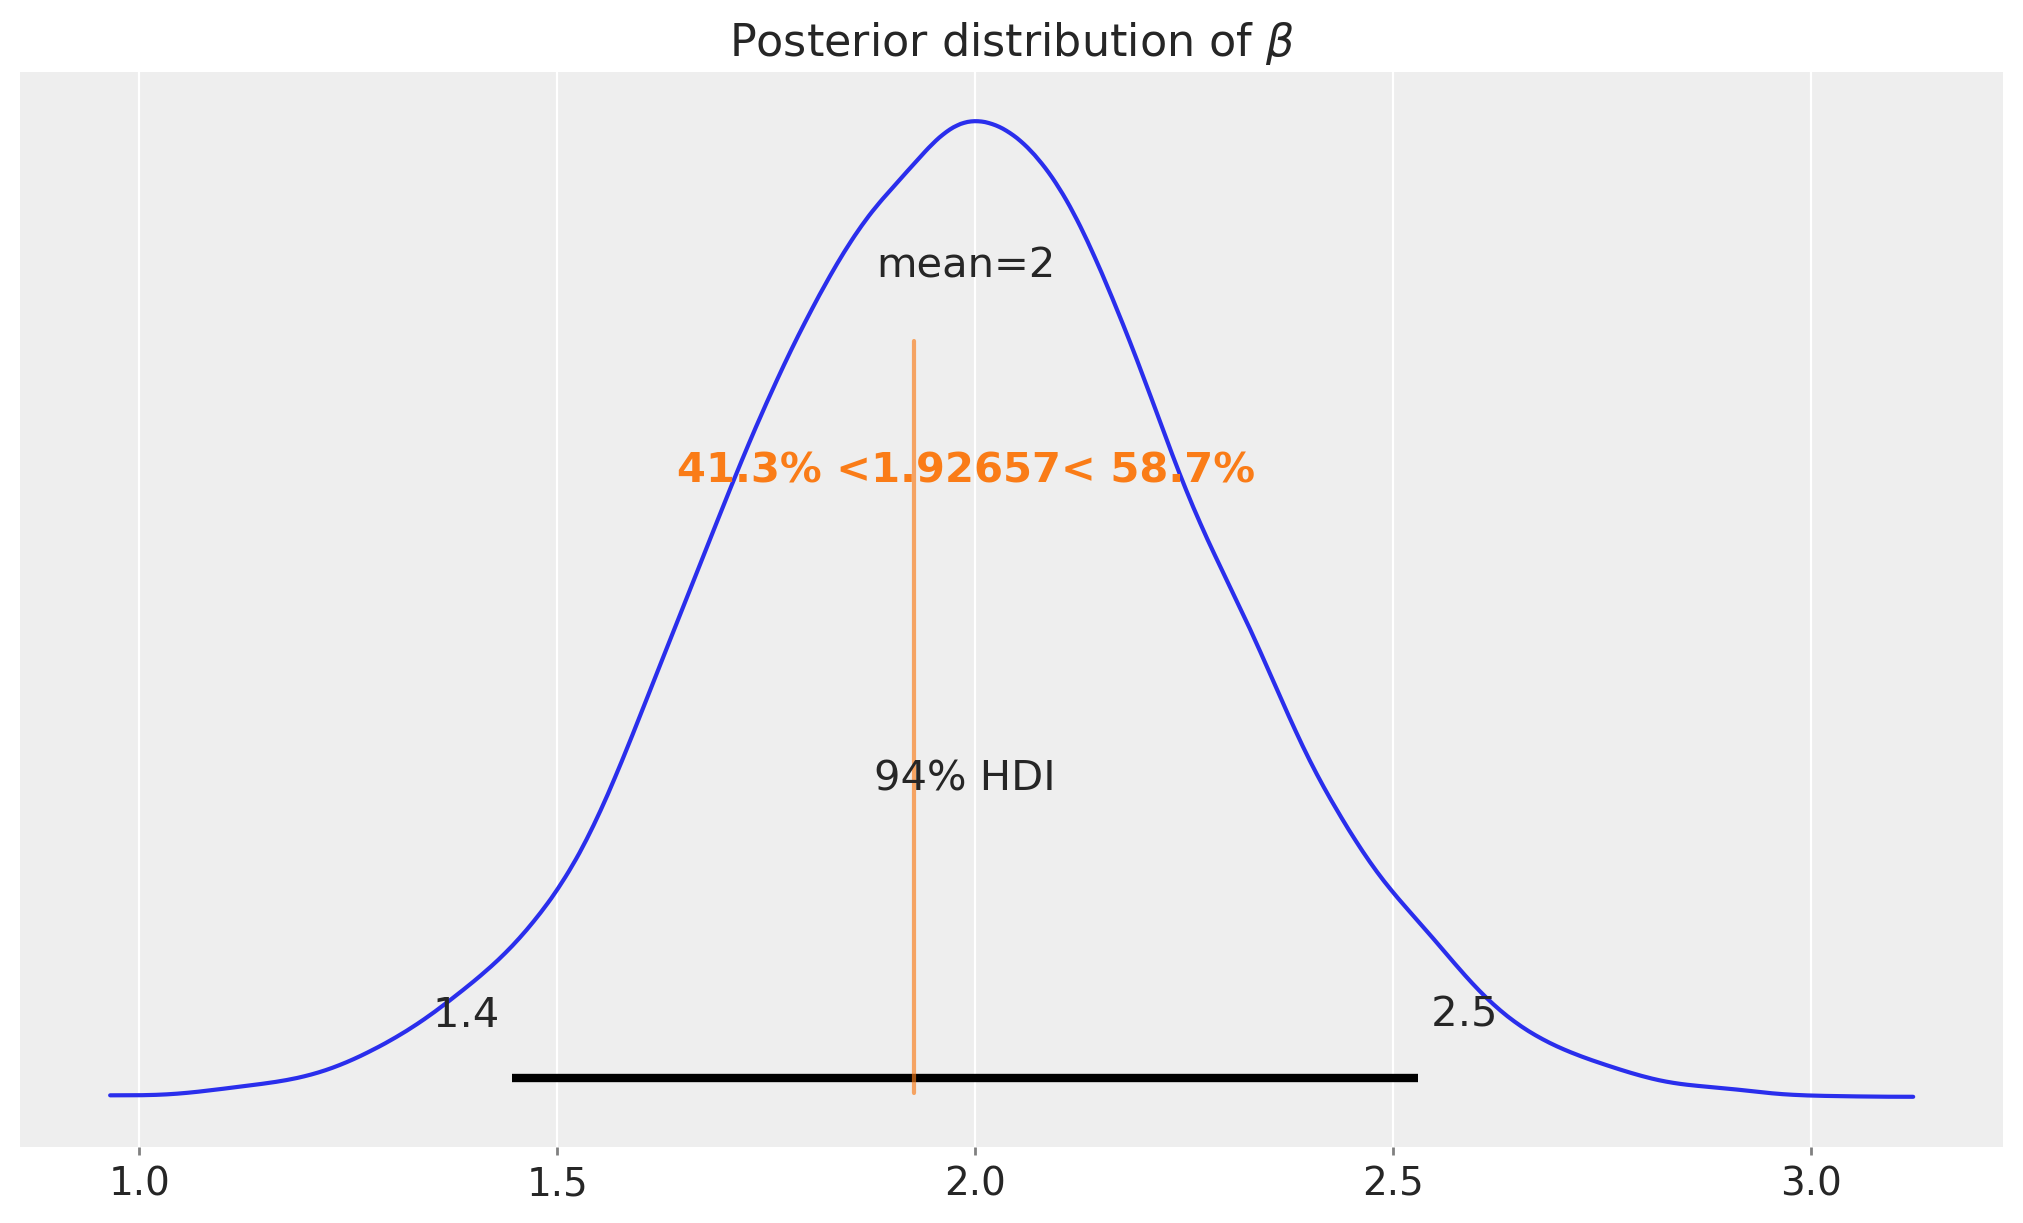

In [7]:
mcmc_difference_in_means = MCMC(
    sampler=NUTS(difference_in_means_model),
    num_warmup=1_500,
    num_samples=4_000,
    num_chains=4,
)

rng_key, rng_subkey = random.split(rng_key)
mcmc_difference_in_means.run(rng_subkey, revenue1, ad_campaign)

idata_difference_in_means = az.from_numpyro(mcmc_difference_in_means)

fig, ax = plt.subplots()
az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax
)
ax.set_title(r"Posterior distribution of $\beta$");

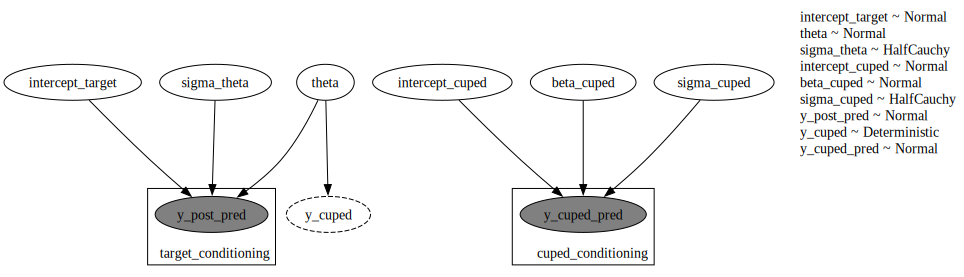

In [8]:
def cuped_model(y_post, treatment, y_pre) -> None:
    n_samples = len(ad_campaign)

    intercept_target = numpyro.sample("intercept_target", dist.Normal(0, 2))
    theta = numpyro.sample("theta", dist.Normal(0, 3))
    sigma_theta = numpyro.sample("sigma_theta", dist.HalfCauchy(2))

    intercept_cuped = numpyro.sample("intercept_cuped", dist.Normal(0, 2))
    beta_cuped = numpyro.sample("beta_cuped", dist.Normal(0, 3))
    sigma_cuped = numpyro.sample("sigma_cuped", dist.HalfCauchy(2))

    mu_target = intercept_target + theta * y_pre

    with numpyro.plate("target_conditioning", n_samples):
        numpyro.sample("y_post_pred", dist.Normal(mu_target, sigma_theta), obs=y_post)

    y_cuped = numpyro.deterministic(
        "y_cuped", y_post - theta * (y_pre - jnp.mean(y_pre))
    )

    with numpyro.plate("cuped_conditioning", n_samples):
        numpyro.sample(
            "y_cuped_pred",
            dist.Normal(intercept_cuped + beta_cuped * treatment, sigma_cuped),
            obs=y_cuped,
        )


numpyro.render_model(
    cuped_model,
    model_args=(revenue1, ad_campaign, revenue0),
    render_distributions=True,
    render_params=True,
)

In [9]:
mcmc_cuped = MCMC(
    sampler=NUTS(cuped_model),
    num_warmup=1_500,
    num_samples=4_000,
    num_chains=4,
)
rng_key, rng_subkey = random.split(rng_key)
mcmc_cuped.run(rng_subkey, revenue1, ad_campaign, revenue0)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

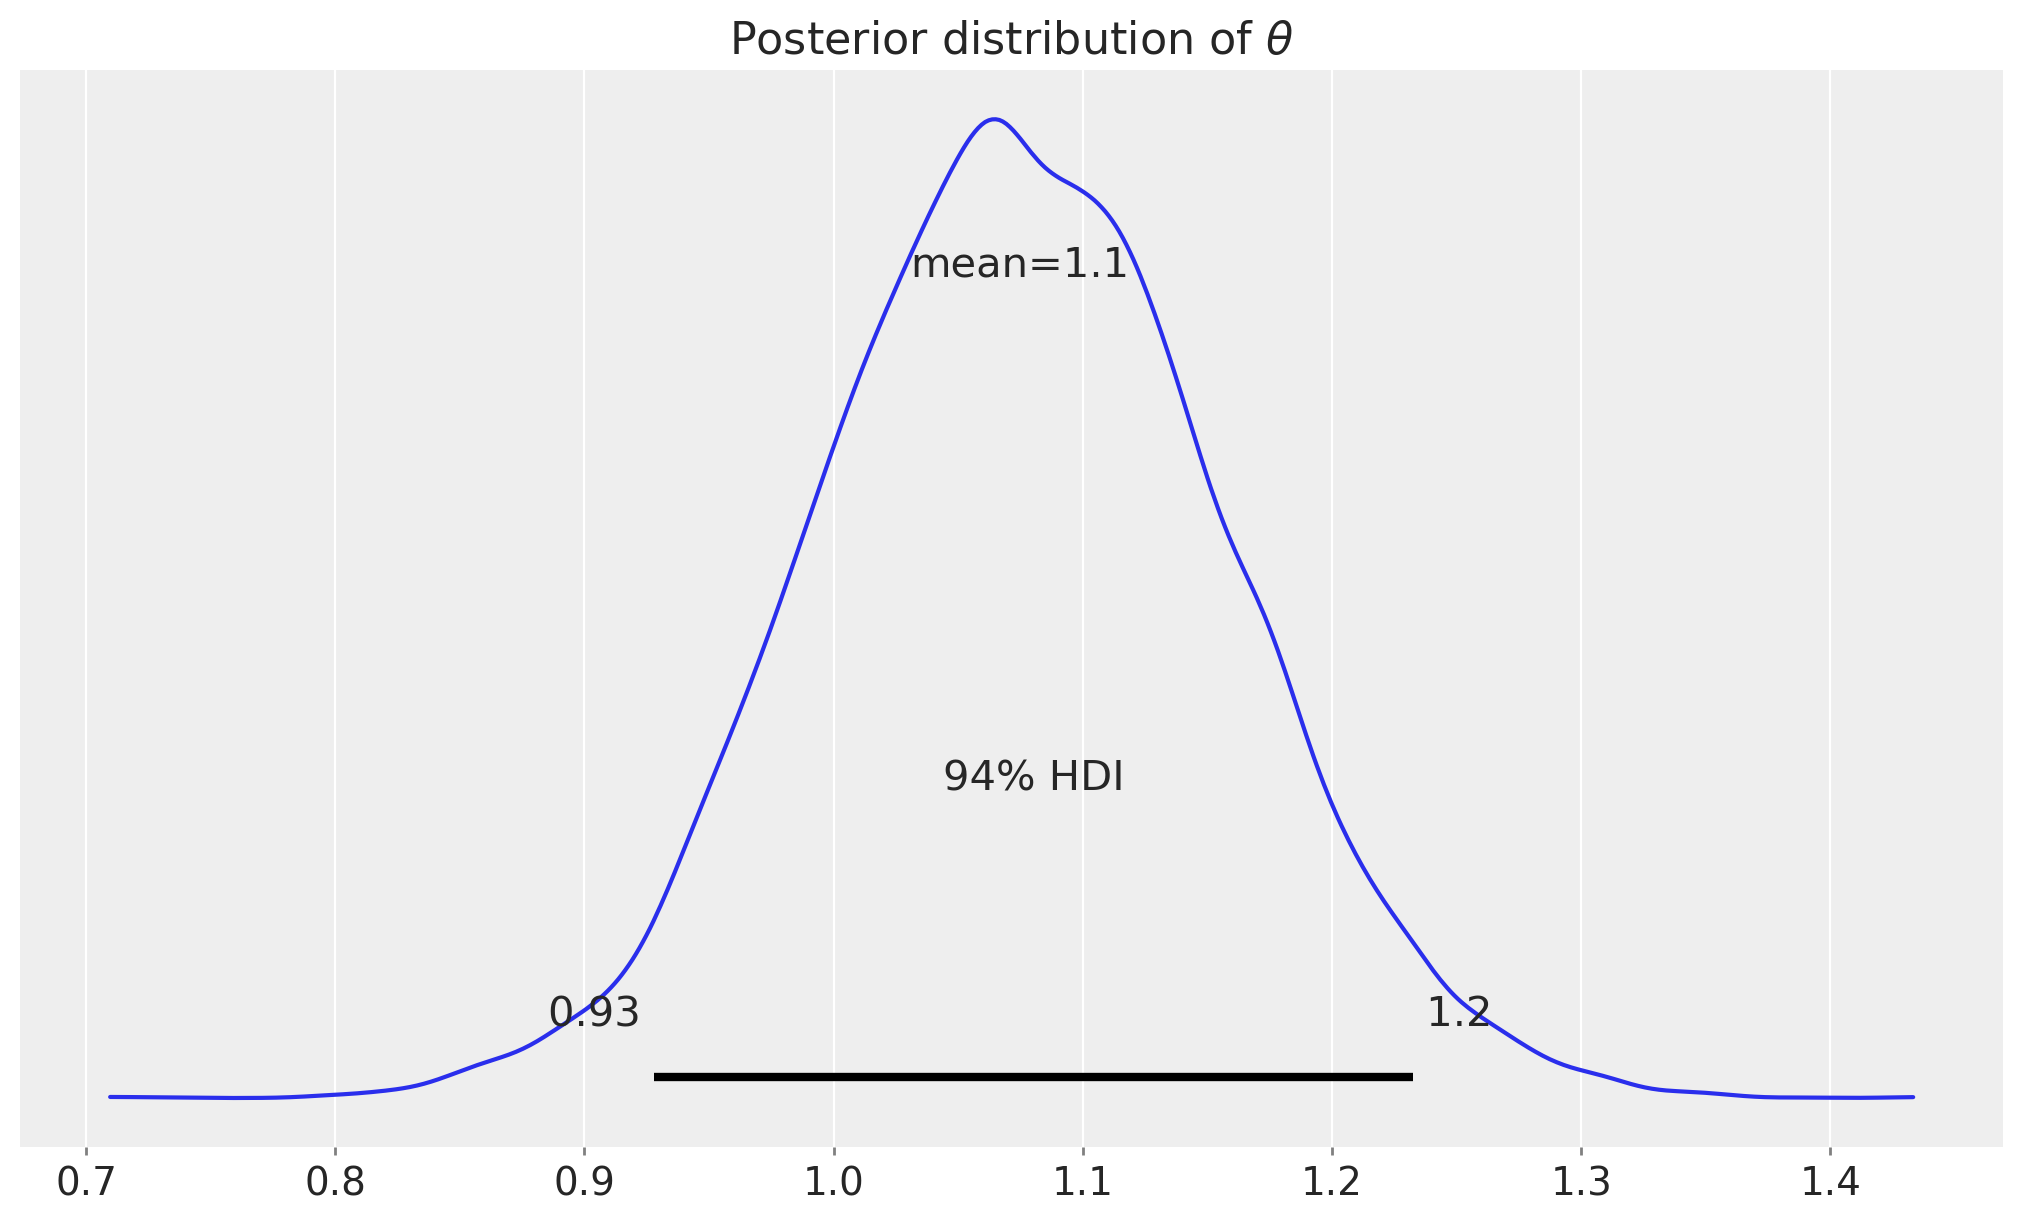

In [10]:
idata_cuped = az.from_numpyro(mcmc_cuped)
fig, ax = plt.subplots()
az.plot_posterior(idata_cuped, var_names=["theta"], ax=ax)
ax.set_title(r"Posterior distribution of $\theta$");

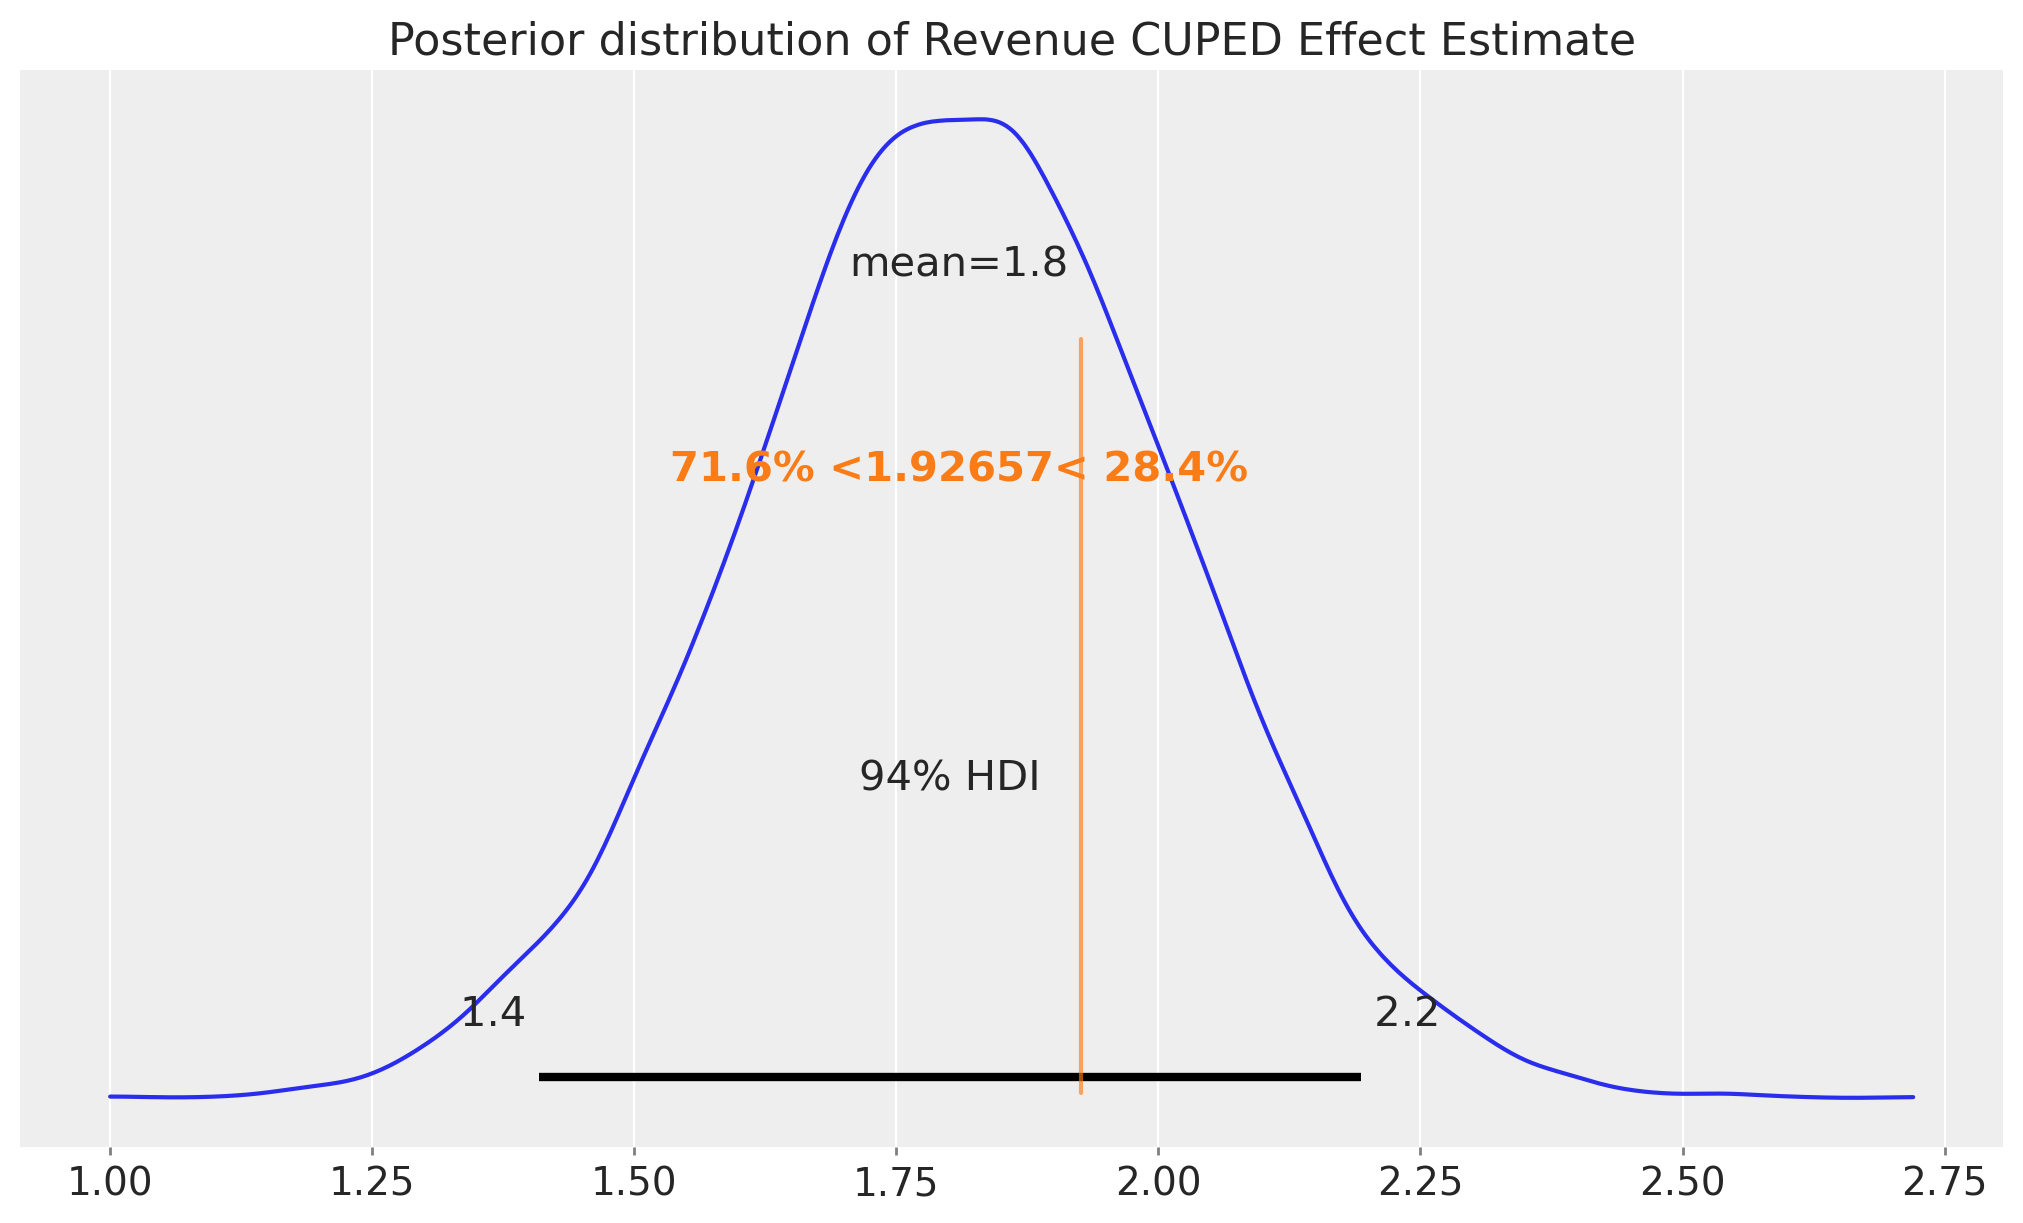

In [11]:
fig, ax = plt.subplots()
az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax
)
ax.set_title("Posterior distribution of Revenue CUPED Effect Estimate");

In [12]:
idata_cuped["posterior"]["beta_cuped"].std().item()

0.20659896731376648

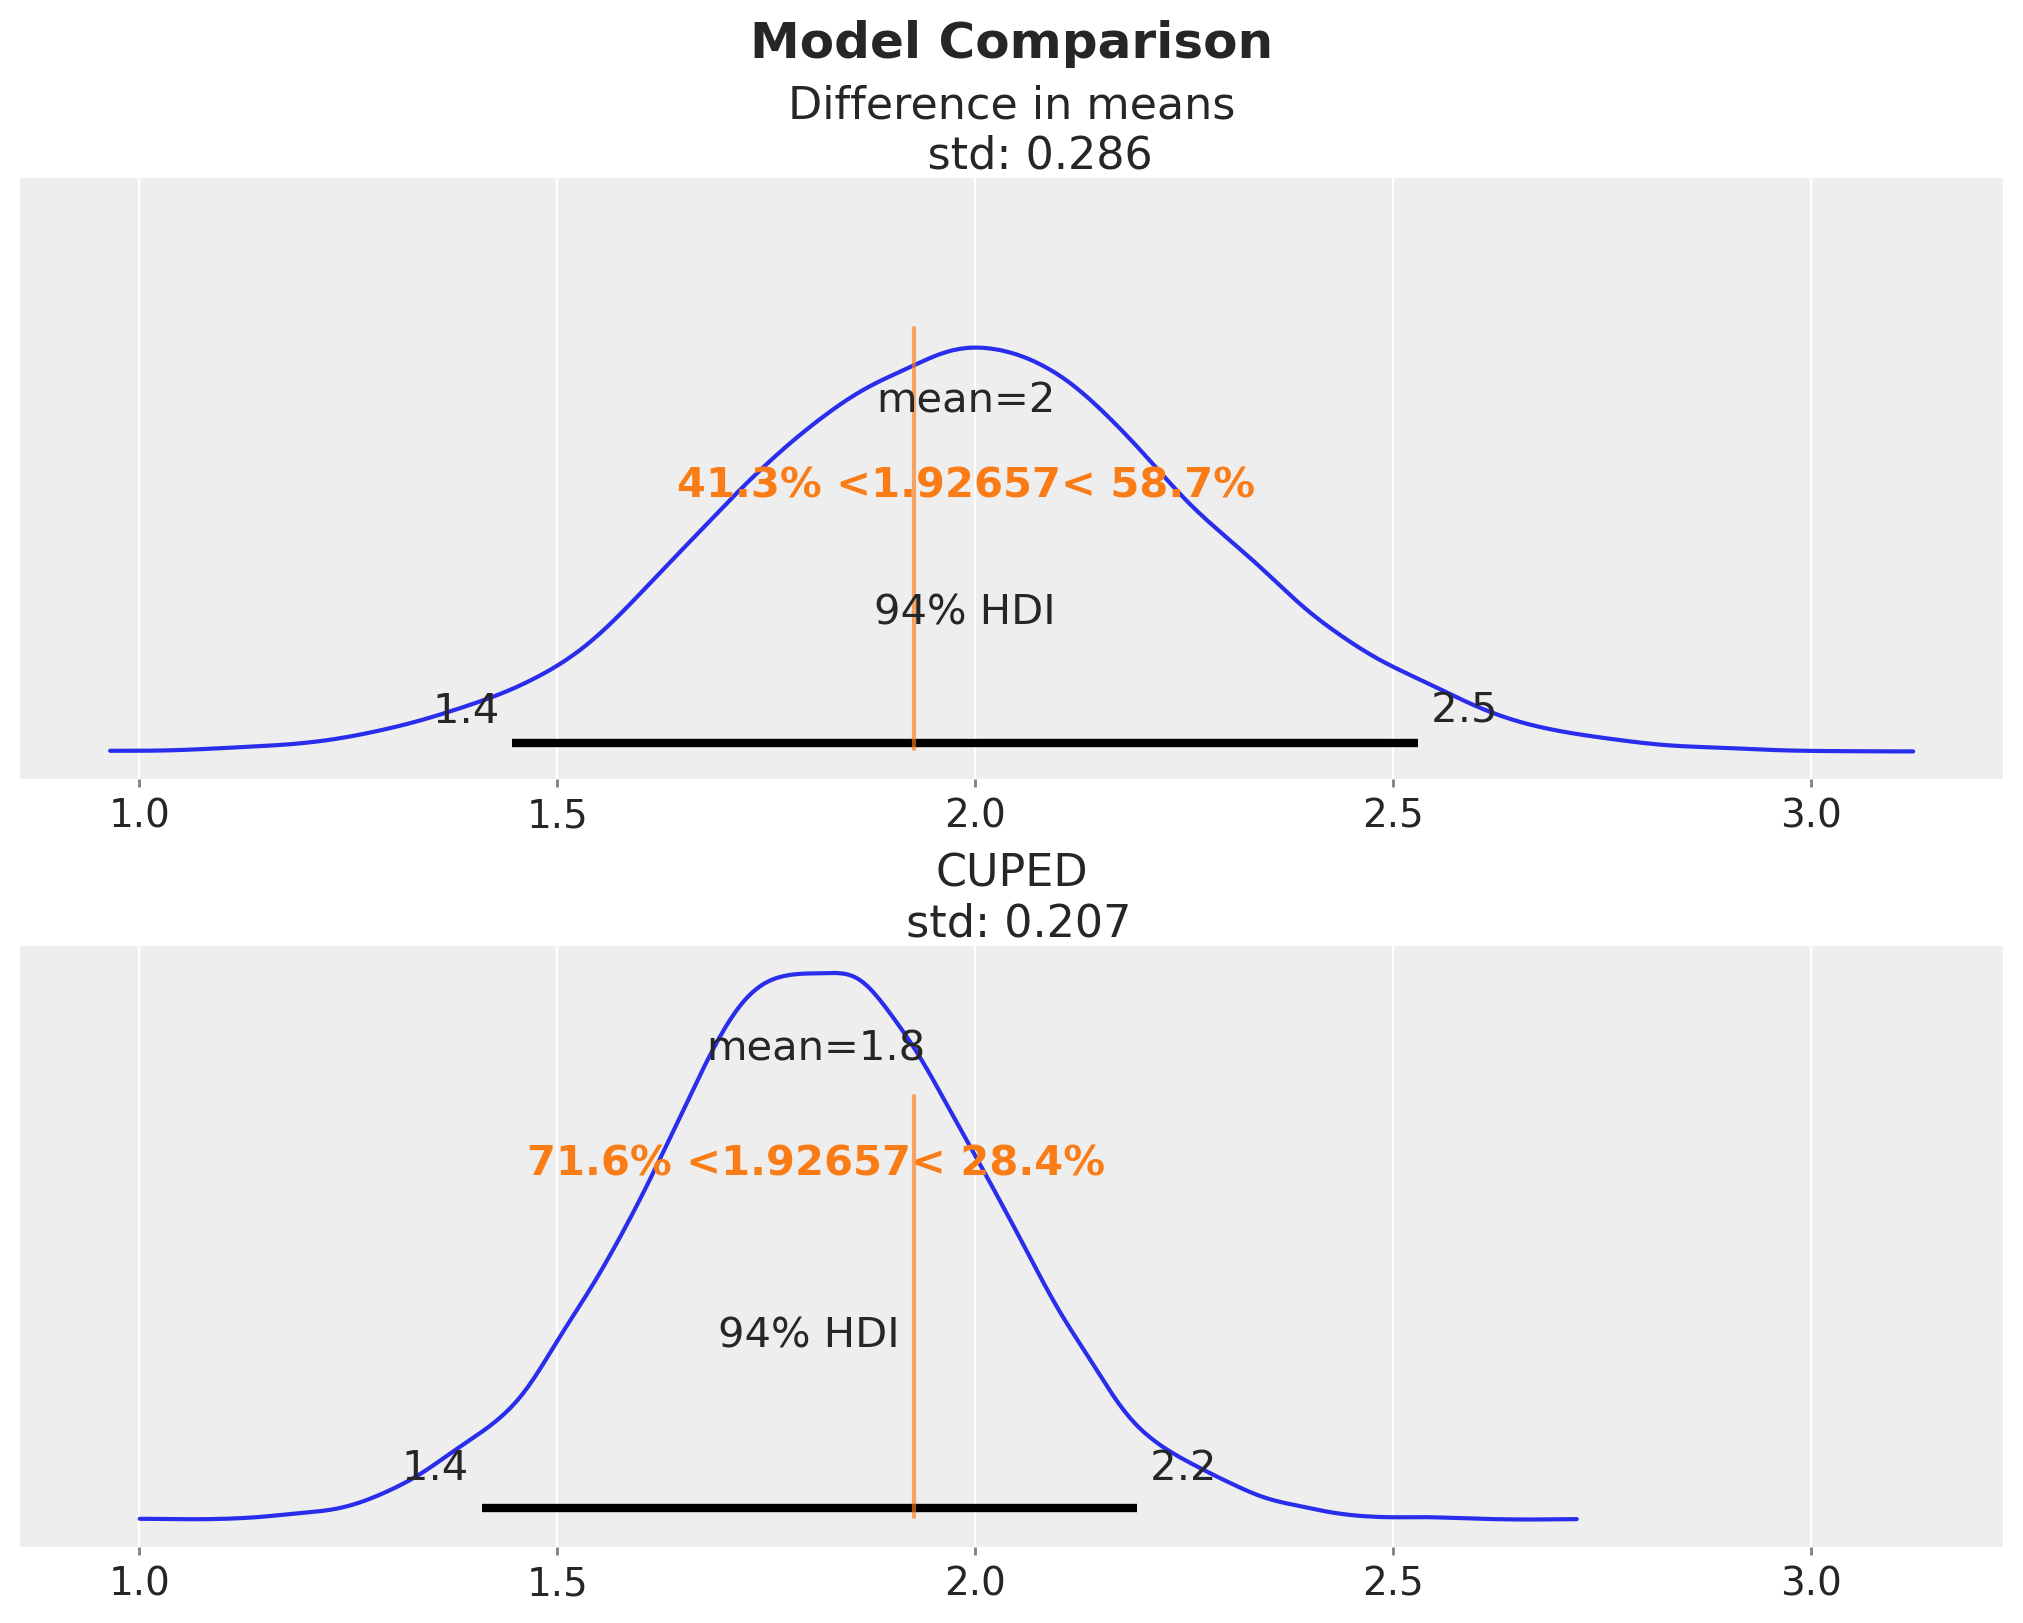

In [13]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=True,
    sharey=True,
    layout="constrained",
)

az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax[0]
)
ax[0].set_title(
    f"""Difference in means
    std: {idata_difference_in_means['posterior']['beta'].std().item():.3f}"""
)

az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax[1]
)
ax[1].set_title(
    f"CUPED\n std: {idata_cuped['posterior']['beta_cuped'].std().item():.3f}"
)

fig.suptitle("Model Comparison", fontsize=18, fontweight="bold");

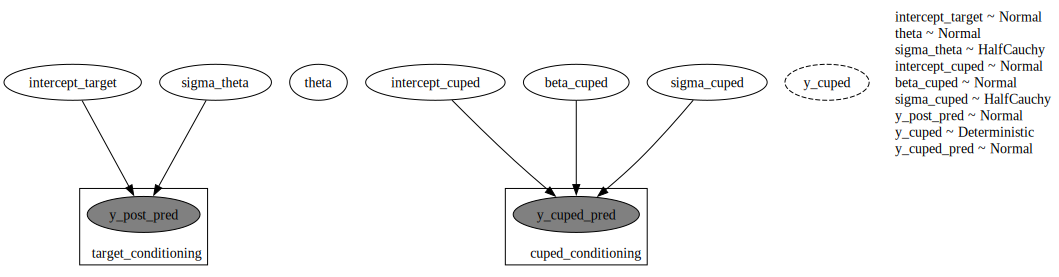

In [14]:
do_cuped_model = do(
    cuped_model, data={"theta": idata_cuped["posterior"]["theta"].mean().item()}
)

numpyro.render_model(
    do_cuped_model,
    model_args=(revenue1, ad_campaign, revenue0),
    render_distributions=True,
    render_params=True,
)

In [15]:
mcmc_do_cuped = MCMC(
    sampler=NUTS(do_cuped_model),
    num_warmup=1_500,
    num_samples=4_000,
    num_chains=4,
)
rng_key, rng_subkey = random.split(rng_key)
mcmc_do_cuped.run(rng_subkey, revenue1, ad_campaign, revenue0)

idata_do_cuped = az.from_numpyro(mcmc_do_cuped)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

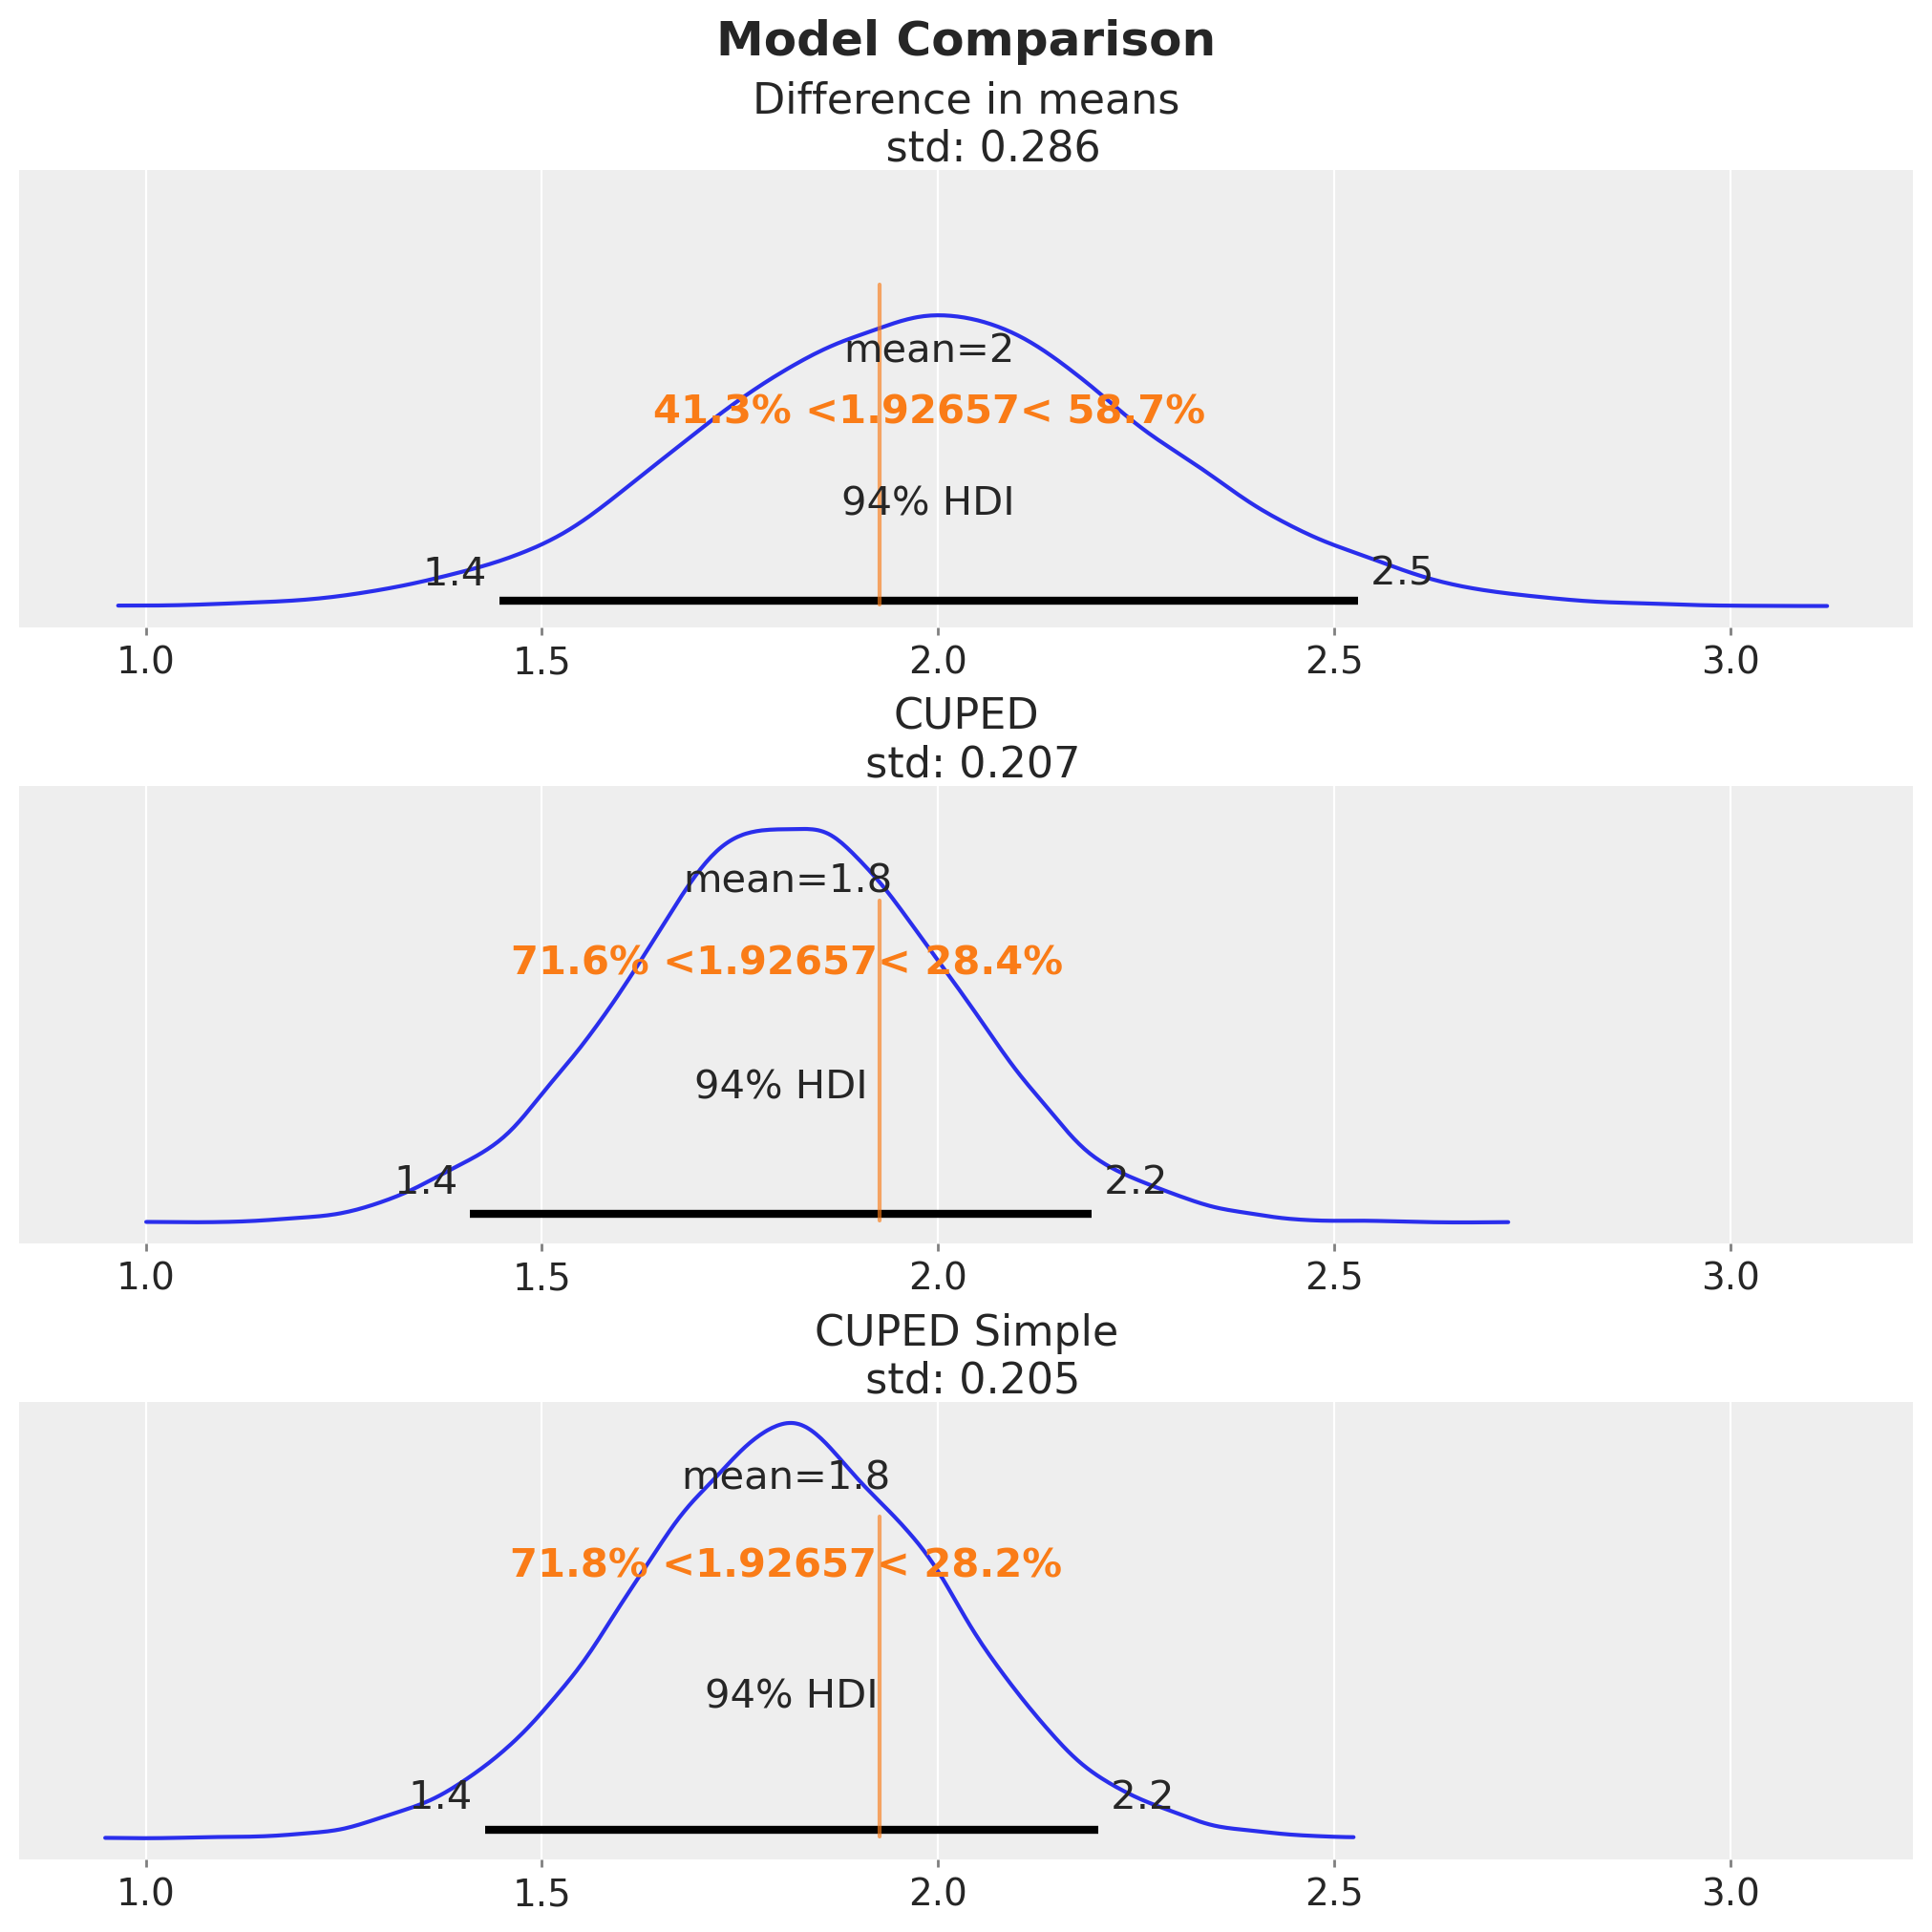

In [16]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax[0]
)
ax[0].set_title(
    f"""Difference in means
    std: {idata_difference_in_means['posterior']['beta'].std().item():.3f}"""
)

az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax[1]
)
ax[1].set_title(
    f"CUPED\n std: {idata_cuped['posterior']['beta_cuped'].std().item():.3f}"
)

az.plot_posterior(
    idata_do_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax[2]
)
ax[2].set_title(
    f"CUPED Simple\n std: {idata_do_cuped['posterior']['beta_cuped'].std().item():.3f}"
)

fig.suptitle("Model Comparison", fontsize=18, fontweight="bold");